In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import csv
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy

In [ ]:
url = "https://storage.googleapis.com/doggies-doggies/Monkeys.zip"
pathto = "/content/monkey"
path = keras.utils.get_file("Monkeys.zip",origin = url)
import zipfile
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(pathto)



In [ ]:
train_dir = os.path.join(pathto, 'training/training')
validation_dir = os.path.join(pathto, 'validation/validation')
train_dataset = tf.keras.utils.image_dataset_from_directory( train_dir, labels="inferred",color_mode="rgb", image_size=(160,160), batch_size= 30)

Found 1097 files belonging to 10 classes.


In [ ]:

validation_dataset = tf.keras.utils.image_dataset_from_directory( validation_dir, labels="inferred",color_mode="rgb", image_size=(160,160), batch_size= 30)

Found 272 files belonging to 10 classes.


In [ ]:

train_dataset.class_names = ["Mantled Howler","Patas Monkey","Bald Uakari","Japanese Macaque", "Pygmy Marmoset","White Headed Capuchin","Silvery Marmoset", "Common Squirrel Monkey", "Black Headed Night Monkey","Nilgiri Langur"]


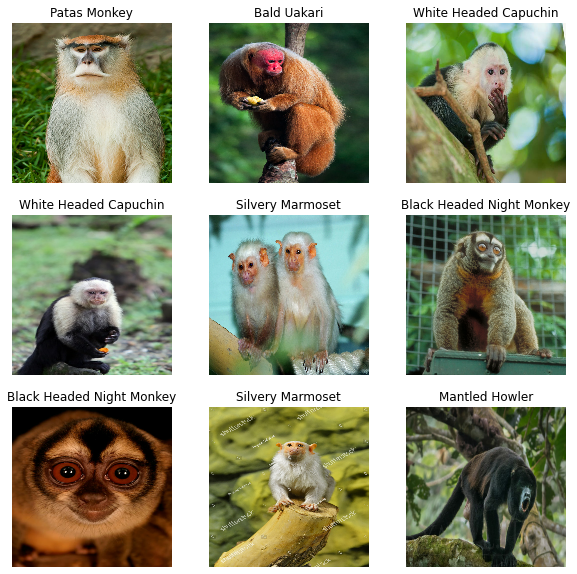

In [ ]:
class_names = train_dataset.class_names
{'n0': "Mantled Howler", 'n1': "Patas Monkey", 'n2': "Bald Uakari", 'n3': "Japanese Macaque", 'n4': "Pygmy Marmoset",'n5': "White Headed Capuchin", 'n6': "Silvery Marmoset", 'n7': "Common Squirrel Monkey", 'n8': "Black Headed Night Monkey",'n9': "Nilgiri Langur"}
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=10>

In [ ]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 2


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SIZE=(160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 5, 5, 1280)


In [ ]:
# Freezing the base model
base_model.trainable = False

In [ ]:
# Looking at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(30, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(30, 10)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))

x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
# Lets see how many trainable variables we have
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

8/8 [==============================] - 3s 11ms/step - loss: 2.9612 - accuracy: 0.0896


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.96
initial accuracy: 0.09


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
37/37 [==============================] - 9s 151ms/step - loss: 2.8042 - accuracy: 0.0957 - val_loss: 2.3453 - val_accuracy: 0.2075
Epoch 2/10
37/37 [==============================] - 7s 153ms/step - loss: 2.2579 - accuracy: 0.2279 - val_loss: 1.9227 - val_accuracy: 0.3491
Epoch 3/10
37/37 [==============================] - 7s 156ms/step - loss: 1.8552 - accuracy: 0.3601 - val_loss: 1.5090 - val_accuracy: 0.5943
Epoch 4/10
37/37 [==============================] - 7s 153ms/step - loss: 1.4895 - accuracy: 0.5406 - val_loss: 1.2865 - val_accuracy: 0.6934
Epoch 5/10
37/37 [==============================] - 7s 152ms/step - loss: 1.2267 - accuracy: 0.6645 - val_loss: 1.0822 - val_accuracy: 0.7689
Epoch 6/10
37/37 [==============================] - 7s 155ms/step - loss: 1.0269 - accuracy: 0.7639 - val_loss: 0.8769 - val_accuracy: 0.8774
Epoch 7/10
37/37 [==============================] - 7s 152ms/step - loss: 0.8512 - accuracy: 0.8314 - val_loss: 0.7335 - val_accuracy: 0.9057
Epoch 

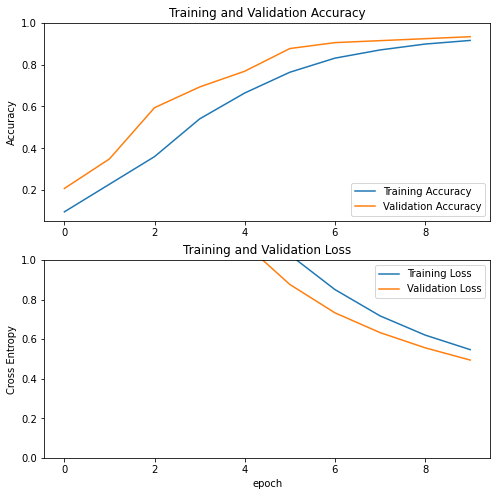

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Now to fine tune the base model

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
37/37 [==============================] - 12s 177ms/step - loss: 0.2515 - accuracy: 0.9426 - val_loss: 0.1734 - val_accuracy: 0.9481
Epoch 11/20
37/37 [==============================] - 7s 156ms/step - loss: 0.1338 - accuracy: 0.9672 - val_loss: 0.0988 - val_accuracy: 0.9811
Epoch 12/20
37/37 [==============================] - 7s 154ms/step - loss: 0.0732 - accuracy: 0.9881 - val_loss: 0.0976 - val_accuracy: 0.9764
Epoch 13/20
37/37 [==============================] - 7s 154ms/step - loss: 0.0439 - accuracy: 0.9954 - val_loss: 0.0993 - val_accuracy: 0.9717
Epoch 14/20
37/37 [==============================] - 7s 157ms/step - loss: 0.0381 - accuracy: 0.9909 - val_loss: 0.0743 - val_accuracy: 0.9858
Epoch 15/20
37/37 [==============================] - 7s 155ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.0524 - val_accuracy: 0.9858
Epoch 16/20
37/37 [==============================] - 7s 155ms/step - loss: 0.0188 - accuracy: 0.9973 - val_loss: 0.0751 - val_accuracy: 0.976

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

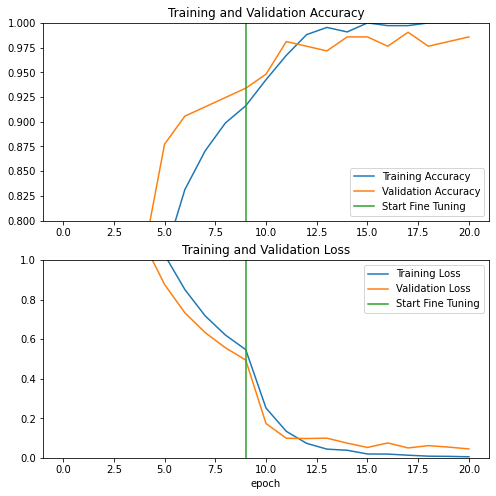

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 2s 14ms/step - loss: 0.0672 - accuracy: 0.9667
Test accuracy : 0.9666666388511658


1/1 [==============================] - 1s 787ms/step
Predictions:

Predictions:
 [1.57065254e-314 1.60670710e-314 1.60670709e-314 1.97626258e-323
 2.12199579e-314 6.92746746e-310 9.88131292e-324 0.00000000e+000
 2.24453470e-316 1.24337779e-314 1.61251776e-314 1.61251786e-314
 3.45845952e-323 0.00000000e+000 0.00000000e+000 2.96439388e-323
 0.00000000e+000 1.64125370e-314 1.55820112e-314 1.55820122e-314
 3.45845952e-323 0.00000000e+000 0.00000000e+000 2.96439388e-323
 0.00000000e+000 1.65590647e-314 3.45845952e-323 1.65590496e-314
 3.45845952e-323 5.43230923e-312 5.00000000e+000 1.00000000e+000
 6.00000000e+000 9.00000000e+000 6.00000000e+000 2.00000000e+000
 6.00000000e+000 4.00000000e+000 0.00000000e+000 7.00000000e+000
 1.00000000e+000 5.00000000e+000 7.00000000e+000 4.00000000e+000
 6.00000000e+000 6.00000000e+000 1.00000000e+000 4.00000000e+000
 1.00000000e+000 2.00000000e+000 0.00000000e+000 4.00000000e+000
 0.00000000e+000 1.00000000e+000 7.00000000e+000 1.00000000e+000
 0.000000

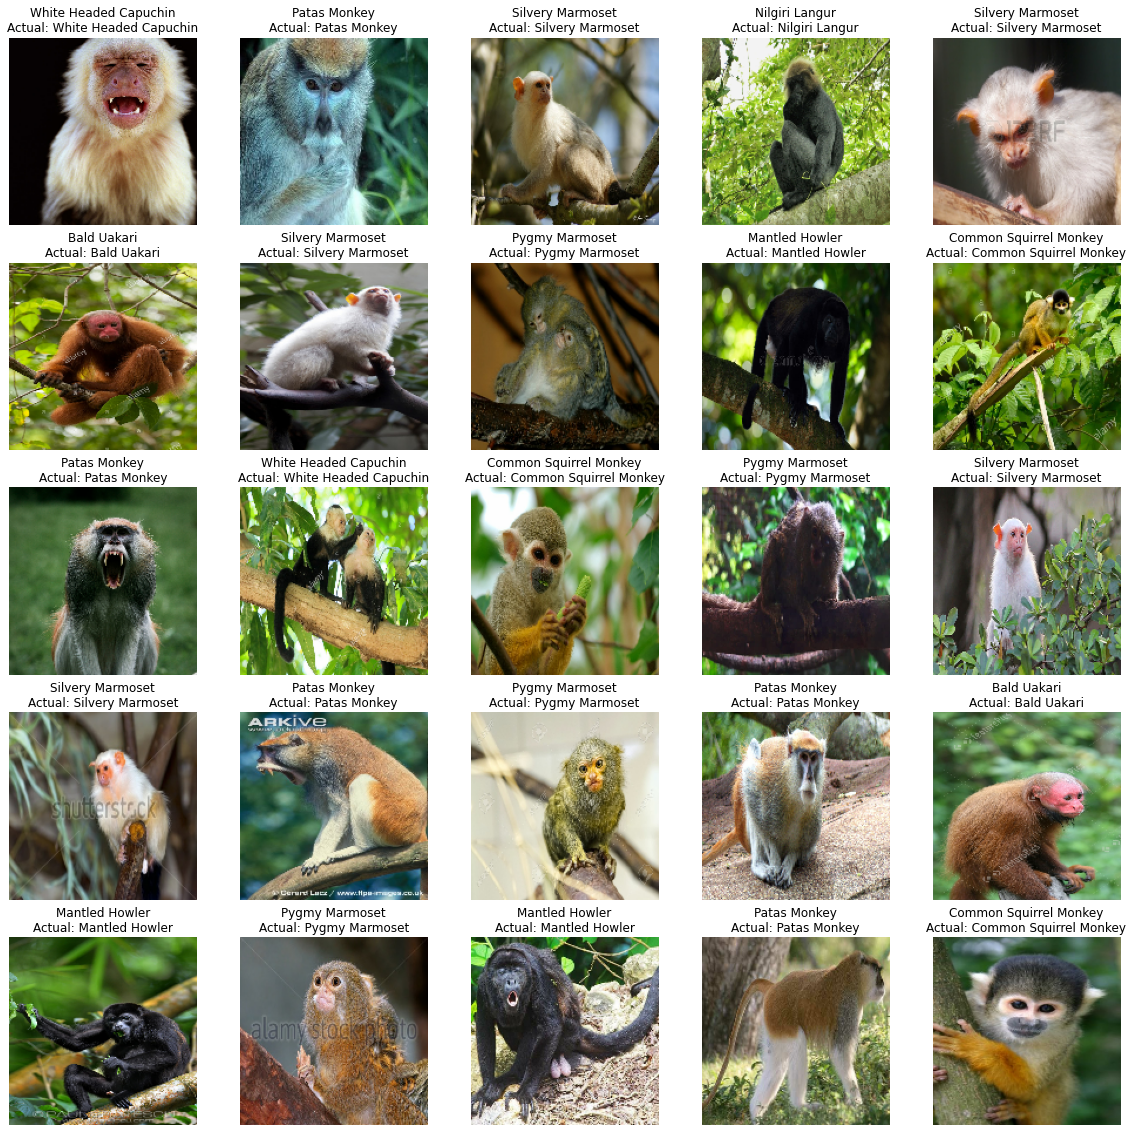

In [ ]:
import numpy as np
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.LeakyReLU()])
predictions = probability_model.predict(image_batch)

print('Predictions:\n')
a = np.empty(len(predictions))
for i in predictions:
  sx = np.argmax(i)
  a = np.append(a, sx)
print('Predictions:\n', a)
print('Labels:\n', label_batch)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss3, accuracy3 = model.evaluate(train_dataset)
print('Train accuracy :', accuracy3)
plt.figure(figsize=(20, 20))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title( class_names[np.argmax(predictions[i])] + "\n" + "Actual: " + class_names[(label_batch[i])])
  plt.axis("off")





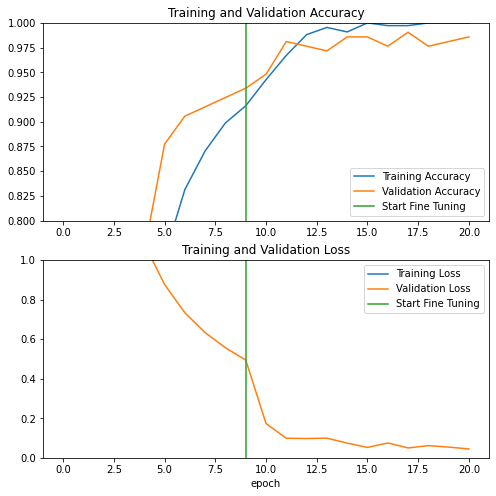

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()